In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sedmodels import Sedmodel
from mlmodels import train_encoder

In [2]:
model = Sedmodel(add_dust=False, add_neb=False, add_zred=True, add_burst=False)

Number of dimensions: 6

Filters:
  [<class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0)]

Free Parameters:
  ['zred', 'mass', 'logzsol', 'dust2', 'tage', 'tau']

Fixed Parameters:
  ['sfh', 'imf_type', 'dust_type']


# Compute grid of models

In [3]:
if True: # Load model grid

    num_samples_per_dim = 6
    u_grid = np.load('data/u_grid_'+str(num_samples_per_dim)+'.npy')
    theta_grid = np.load('data/theta_grid_'+str(num_samples_per_dim)+'.npy')
    phot_grid = np.load('data/phot_grid_'+str(num_samples_per_dim)+'.npy')

    num_samples = u_grid.shape[0]
    print("\nNumber of samples:", num_samples)

else: # Create and write model grid

    if True:
        num_samples_per_dim = 6
        num_samples = num_samples_per_dim**model.num_dim
        grids = np.meshgrid(*[np.linspace(0, 1, num_samples_per_dim) for _ in range(model.num_dim)])
        u_grid = np.vstack([x.ravel() for x in grids]).T
        del grids
    else:
        num_samples = 10
        num_samples_per_dim = 0
        u_grid = np.random.uniform(size=num_samples*model.num_dim).reshape((num_samples, model.num_dim))
        
    print("\nNumber of samples:", num_samples)

    theta_grid, phot_grid, times = model.compute_photsed_grid(u_grid, plot_sed=False)
    
    np.save('data/u_grid_'+str(num_samples_per_dim)+'.npy', u_grid)
    np.save('data/theta_grid_'+str(num_samples_per_dim)+'.npy', theta_grid)
    np.save('data/phot_grid_'+str(num_samples_per_dim)+'.npy', phot_grid)
    
    print('Done in', np.sum(times), 'sec')
    
    plt.hist(times)
    
phot_grid = -2.5*np.log10(phot_grid)


Number of samples: 46656


## Prepare training and validation

In [4]:
num_samples = u_grid.shape[0]
print("Number of samples:", num_samples)

#ind_train = np.arange(0, int(1*n_seds/8))
ind_all = np.arange(num_samples)
np.random.shuffle(ind_all)

split = int(0.8*num_samples)
ind_train = ind_all[:split]
ind_valid = ind_all[split:]

print("Number of training points:", ind_train.size)
print("Number of validation points:", ind_valid.size)

print("Dimension of parameter space", u_grid.shape[1])
print("Dimension of model space", phot_grid.shape[1])

train_params, train_models = u_grid[ind_train, :], phot_grid[ind_train, :]
valid_params, valid_models = theta_grid[ind_valid, :], phot_grid[ind_valid, :]

Number of samples: 46656
Number of training points: 32659
Number of validation points: 13997
Dimension of parameter space 6
Dimension of model space 5


# Auto-encoder

In [5]:
batch_size = 2048
keep_prob = 0.8
num_epoch = 2000
num_latent = 3
learning_rate = 0.01
num_hiddens = [200]

In [6]:
train_params_out, train_latent, train_models_out, valid_params_out, valid_latent, valid_models_out = \
    train_encoder(train_params, train_models, valid_params, valid_models,
                  num_latent, num_hiddens, num_epoch, learning_rate, batch_size, keep_prob)

0 4.173e+02 ; 100 2.087e+00 ; 200 1.792e+00 ; 

## Verify latent reconstruction quality on training and validation (interpolation)

/Users/bl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([13996.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 array([1.0000e-02, 1.0009e+01, 2.0008e+01, 3.0007e+01, 4.0006e+01,
        5.0005e+01, 6.0004e+01, 7.0003e+01, 8.0002e+01, 9.0001e+01,
        1.0000e+02]),
 <a list of 6 Lists of Patches objects>)

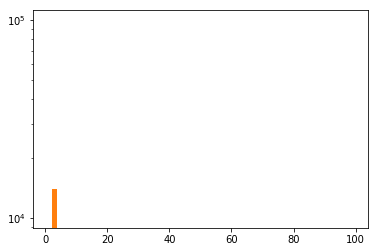

In [7]:
plt.hist(valid_params_out/valid_params, log=True, range=[1e-2, 1e2])

In [8]:
valid_params_out/valid_params

/Users/bl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[-2.77341927e+07,  6.21479640e-01, -7.96950832e+06,
                   -inf, -8.10835402e+05, -4.75822369e+06],
       [-1.05738088e+08,  5.75666000e-01,  1.69054337e+08,
        -4.76254450e+06,  1.50384933e+06, -5.55998867e+05],
       [-4.61545173e+11,  3.26333891e-01, -1.73903888e+11,
                   -inf,  7.74994534e+10, -1.21261283e+10],
       ...,
       [-1.00137011e+11,  6.96034679e-01,  4.77156783e+09,
        -3.21764940e+08, -5.05055872e+07, -2.89042821e+08],
       [-5.47311216e+07,  5.92216720e-01, -5.15807347e+07,
        -1.25642225e+07,  1.46456490e+06, -3.40663065e+07],
       [-2.98884267e+10,  3.95258186e-01, -1.73749698e+10,
        -8.69970368e+09, -3.68274847e+08, -2.21446703e+10]])

In [12]:
train_params_out/train_params

/Users/bl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[ 0.84411681,  0.54263836,  0.42451602,  1.87996715,  0.48874269,
         0.62415898],
       [ 1.22083704,  1.32355526,  0.57231586,         inf,        -inf,
         0.8152885 ],
       [ 0.88998342, -0.07631801,  2.38026798,         inf,  0.46260846,
         0.98109595],
       ...,
       [ 0.77429771,  0.99120088,  0.61843236,  0.84437691,  2.62472302,
         1.43603514],
       [ 1.070292  ,  0.71496159,  1.07470661,  2.2332868 ,  0.80536634,
         0.5685335 ],
       [ 1.09524414,        -inf,  0.71385264,  1.06676005,  0.65645754,
         1.64878488]])

## Verify model reconstruction quality on training and validation (interpolation)

([array([32659.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([32659.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([32659.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([32659.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([32659.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.])],
 array([1.0000e-02, 1.0009e+01, 2.0008e+01, 3.0007e+01, 4.0006e+01,
        5.0005e+01, 6.0004e+01, 7.0003e+01, 8.0002e+01, 9.0001e+01,
        1.0000e+02]),
 <a list of 5 Lists of Patches objects>)

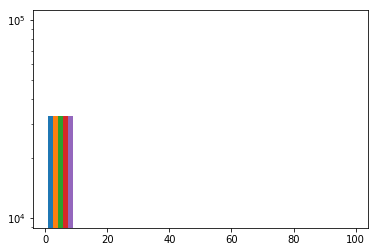

In [9]:
plt.hist(train_models_out/train_models, log=True, range=[1e-2, 1e2])

/Users/bl/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 array([1.0000e-02, 1.0009e+01, 2.0008e+01, 3.0007e+01, 4.0006e+01,
        5.0005e+01, 6.0004e+01, 7.0003e+01, 8.0002e+01, 9.0001e+01,
        1.0000e+02]),
 <a list of 5 Lists of Patches objects>)

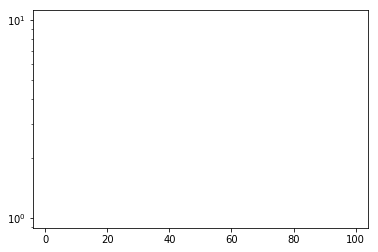

In [10]:
plt.hist(valid_models_out/valid_models, log=True, range=[1e-2, 1e2])

In [11]:
train_models_out/train_models

array([[0.96764563, 0.95824263, 0.95805611, 0.98973074, 0.99953326],
       [0.92137565, 0.93484335, 0.93717223, 0.9376504 , 0.94363593],
       [0.96334167, 0.97238462, 0.97013358, 0.96779693, 0.96440804],
       ...,
       [0.95911341, 0.97657208, 0.97812013, 0.97461548, 0.97048207],
       [1.00213757, 1.00203301, 1.01523247, 1.00998231, 1.00371886],
       [0.94481985, 0.92720379, 0.94105642, 0.97191273, 0.97297658]])

## Visualize projection of parameter space onto latent space